In [1]:
import os
import tensorflow as tf
import tensorflow_io  as tfio
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models
import librosa, librosa.display
from IPython import display

In [2]:
data = "C:/Users/joshr/TESS Toronto emotional speech set data/DATA"
data_dir = pathlib.Path(data)
data_dir

WindowsPath('C:/Users/joshr/TESS Toronto emotional speech set data/DATA')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands_files = np.array(tf.io.gfile.listdir(str(data_dir)))

for i in commands:
    if i.split('_')[1] == "pleasant":
        commands = list(map(lambda x: x.replace(i, "surprise"), commands))
    else:  
        commands = list(map(lambda x: x.replace(i, i.split('_')[1].lower()), commands))
commands = list(set(commands))
print('Commands:', commands)

Commands: ['neutral', 'angry', 'fear', 'surprise', 'sad', 'happy', 'disgust']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands_files[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 2798
Number of examples per label: 200
Example file tensor: tf.Tensor(b'C:\\Users\\joshr\\TESS Toronto emotional speech set data\\DATA\\OAF_pleasant_surprised\\OAF_jar_ps.wav', shape=(), dtype=string)


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands_files[0]))))
j = 0
for i in filenames:
    i = i.numpy()
    if i.decode('UTF-8').endswith('.wav'):
        j+=1
j

Number of total examples: 2798
Number of examples per label: 200


2798

In [7]:
for i in filenames:
    try:
        audio_binary = tf.io.read_file(i)
        audio, _ = tf.audio.decode_wav(contents=audio_binary)
    except Exception as e: 
            print('Issue with image {}'.format(i))
        

In [34]:
train_files = filenames[:2240]
val_files = filenames[2240: 2240+280]
test_files = filenames[-280:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 2240
Validation set size 280
Test set size 280


In [35]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [36]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path,sep=os.path.sep)
  return parts[-2]

In [37]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [38]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

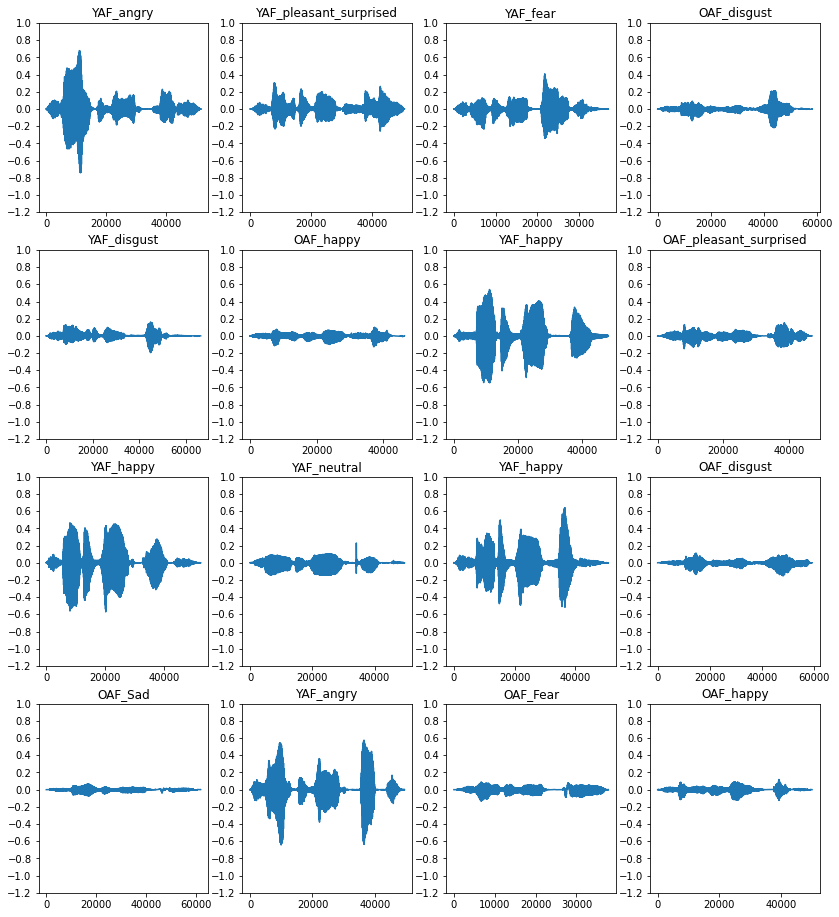

In [39]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 16))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
plt.show()

In [40]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([16000] - tf.shape(waveform),dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [41]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))
spectrogram.shape

Label: YAF_angry
Waveform shape: (51580,)
Spectrogram shape: (124, 129, 1)
Audio playback


TensorShape([124, 129, 1])

In [42]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

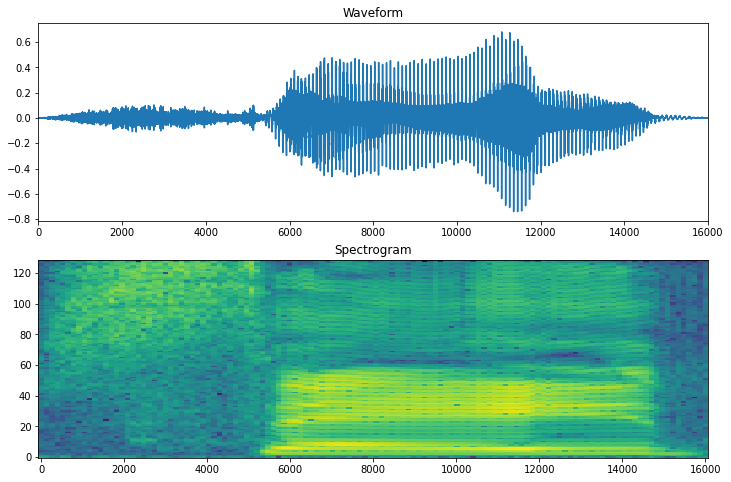

In [43]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [44]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands_files)
  return spectrogram, label_id

In [45]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

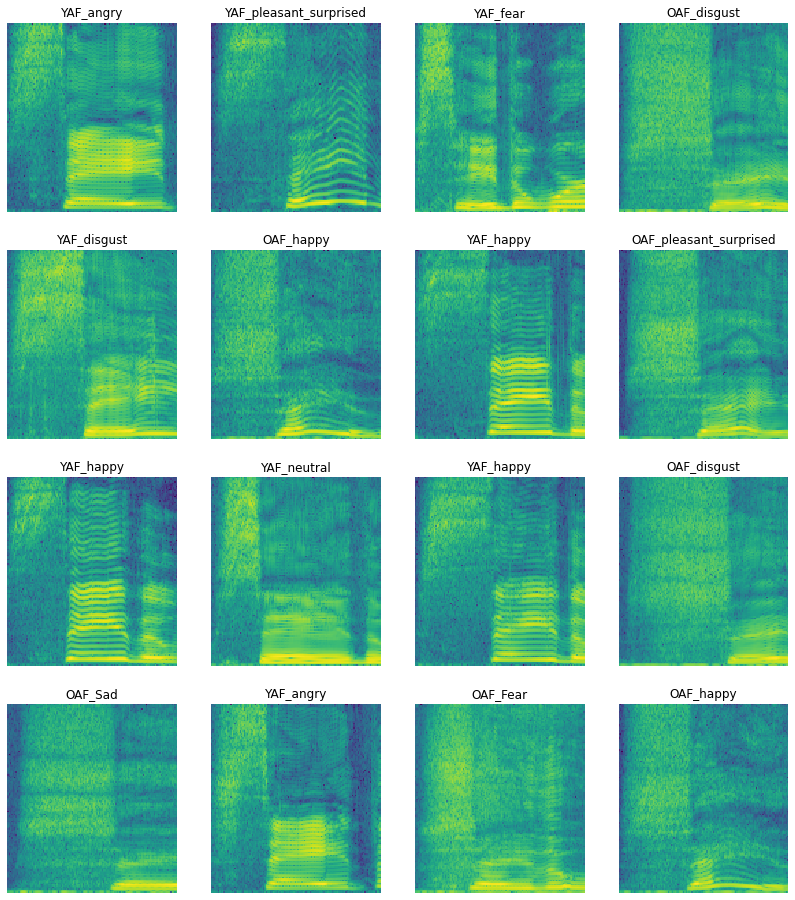

In [46]:
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 16))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands_files[label_id.numpy()])
  ax.axis('off')

plt.show()

In [47]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [48]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [49]:
batch_size = 20
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [50]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
samples, labels = train_ds.as_numpy_iterator().next()
samples.shape
# for i in train_ds:
#     print(i)

(20, 124, 129, 1)

In [51]:
num_labels = len(commands_files)
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(124, 129,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation ='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 122, 127, 16)      160       
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 125, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 62, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 60, 62, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 58, 60, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 30, 32)       0         
 2D)                                                  

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [53]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
112/112 [==============================] - 21s 185ms/step - loss: 0.7022 - accuracy: 0.7915 - val_loss: 0.2932 - val_accuracy: 0.9393
Epoch 2/10
112/112 [==============================] - 19s 172ms/step - loss: 0.1440 - accuracy: 0.9598 - val_loss: 0.1386 - val_accuracy: 0.9607
Epoch 3/10
112/112 [==============================] - 19s 171ms/step - loss: 0.1492 - accuracy: 0.9683 - val_loss: 0.0520 - val_accuracy: 0.9857
Epoch 4/10
112/112 [==============================] - 20s 180ms/step - loss: 0.0540 - accuracy: 0.9848 - val_loss: 0.0278 - val_accuracy: 0.9929
Epoch 5/10
112/112 [==============================] - 20s 176ms/step - loss: 0.0372 - accuracy: 0.9879 - val_loss: 0.0229 - val_accuracy: 0.9964
Epoch 6/10
112/112 [==============================] - 20s 177ms/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 0.0101 - val_accuracy: 0.9964
Epoch 7/10
112/112 [==============================] - 20s 177ms/step - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.0120 - val_ac

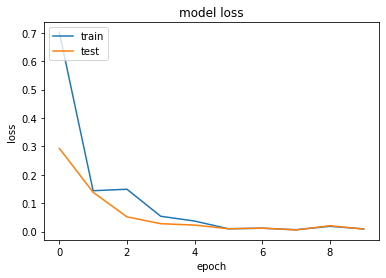

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

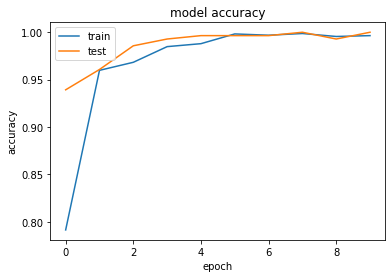

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [68]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


9/9 [==============================] - 0s 47ms/step
Test set accuracy: 99%


In [48]:
emotions = []
paths = []
for i in path_tess:
    directory = os.listdir(data+i)
    for file in directory:
        part = file.split('.')[0]
        part = part.split('_')[2]
        emotions.append(part)
        paths.append(data + i + '/' + file)
        
emotion_df = pd.DataFrame(emotions, columns=['Emotions'])
path_df = pd.DataFrame(paths, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df

,Emotions,Path
0,angry,C:/Users/joshr/TESS Toronto emotional speech s...
1,angry,C:/Users/joshr/TESS Toronto emotional speech s...
2,angry,C:/Users/joshr/TESS Toronto emotional speech s...
3,angry,C:/Users/joshr/TESS Toronto emotional speech s...
4,angry,C:/Users/joshr/TESS Toronto emotional speech s...
...,...,...
2795,sad,C:/Users/joshr/TESS Toronto emotional speech s...
2796,sad,C:/Users/joshr/TESS Toronto emotional speech s...
2797,sad,C:/Users/joshr/TESS Toronto emotional speech s...
2798,sad,C:/Users/joshr/TESS Toronto emotional speech s...


In [138]:
emotions_set = list(set(emotions))
for i in emotions_set:
    files = np.array(Tess_df.Path[Tess_df.Emotions==i])
    for j in files:
        load_wav_16k_mono(j)
get_waveform_and_label('C:/Users/joshr/TESS Toronto emotional speech set data/DATA/OAF_neutral/OAF_bar_neutral.wav')

tf.Tensor(b'C:/Users/joshr/TESS Toronto emotional speech set data/DATA/OAF_neutral/OAF_bar_neutral.wav', shape=(), dtype=string)


(<tf.Tensor: shape=(48876,), dtype=float32, numpy=
 array([ 0.        , -0.00015259, -0.00012207, ...,  0.00045776,
         0.00054932,  0.00045776], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'C:/Users/joshr/TESS Toronto emotional speech set data/DATA/OAF_neutral/OAF_bar_neutral.wav'],
       dtype=object)>)

In [ ]:
filenames = tf.io.gfile.glob(np.array(Tess_df.Path[Tess_df.Emotions=='angry']))
filenames

In [ ]:
np.array(Tess_df.Path[Tess_df.Emotions=='angry'])